# 데이터

In [1]:
# 라이브러리 불러오기
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

import re
from collections import Counter
import sentencepiece as spm
from konlpy.tag import Okt
from konlpy.tag import Mecab
import csv 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
# 한글 폰트에 문제가 생겼을 때

# 한글 폰트 설치
!apt-get update -qq
!apt-get install -qq fonts-nanum

# 설치한 폰트를 matplotlib에서 사용할 수 있도록 설정
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 나눔 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 매니저에 폰트 추가
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')  # 폰트 설정

## 데이터 업로드

#### 학습 데이터 불러오기

프롬프트로 생성된 '일반 대화' 합성 데이터와 원본 데이터가 합쳐진 파일

In [3]:
train_data_path ="./data/conversations.csv"
train_data = pd.read_csv(train_data_path)
# 원본 데이터 저장
origin_data = train_data

In [4]:
train_data.sample(10)

,idx,class,conversation
1827,1827,갈취 대화,야 너희집에 있는 목걸이 그거 나 주면안돼?\n응? 그게무슨소리야\n아주 번쩍하니 ...
2017,2017,갈취 대화,친구야 내가 사정이 안 좋아서 그러는데 10만원만\n너 저번에도 빌렸는데 안 갚았잖...
3542,3542,일반 대화,여행 가서 뭐 할 거야?\n주로 관광하고 맛집 탐방할 거야.\n국내 여행 좋아해?\...
4358,4358,일반 대화,넷플릭스에서 뭐 봤어?\n'기묘한 이야기' 재밌었어.\n영화관 가는 거 좋아해?\n...
1332,1332,갈취 대화,내가 나 만날때 돈 가지고 오라고 했잖아!\n미안해.\n에이. 그럼 내가 나쁜사람처...
3975,3975,일반 대화,"어떤 운동 좋아해?\n나는 축구를 좋아해.\n운동할 때 음악 들어?\n응, 주로 팝..."
1305,1305,갈취 대화,저기 당근이신가요.?\n아 네네 안녕하세요!! 구매자님이시죠!!\n네 제품은 정품 ...
4462,4462,일반 대화,여행 가서 뭐 할 거야?\n주로 관광하고 맛집 탐방할 거야.\n어디로 여행 가고 싶...
1214,1214,기타 괴롭힘 대화,아 나와봐 \n어 여기 내자린데.\n아 잠깐만 나오라고 \n응.\n너 옆에 계속 서...
553,553,일반 대화,"드라마 영화 본 적 있어?\n응, 감동적인 이야기 좋아해.\n넷플릭스에서 뭐 봤어?..."


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4950 entries, 0 to 4949
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   idx           4950 non-null   int64 
 1   class         4950 non-null   object
 2   conversation  4950 non-null   object
dtypes: int64(1), object(2)
memory usage: 116.1+ KB


## Augmentation

## 전처리

### 기본 전처리

#### 중복값 여부 찾아보기

In [6]:
# 중복값 찾기
duplicates = train_data[train_data.duplicated()]
duplicates

,idx,class,conversation


중복값 없음

#### 결측치 여부 확인하기

In [7]:
# 결측치 여부 확인하기
train_data.isnull().sum()

idx             0
class           0
conversation    0
dtype: int64

결측치 없음

#### 클래스 컬럼 인코딩하기

In [8]:
# 'class'를 'type'으로 매핑하는 딕셔너리 생성하기
class_to_type = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}

In [9]:
# 'class' 열을 기반으로 새로운 'type' 열 추가하기
train_data['type'] = train_data['class'].map(class_to_type)

In [10]:
# type 열 추가했는지 확인하기
train_data.head()

,idx,class,conversation,type
0,0,일반 대화,"학교 점심 뭐 나와?\n주로 한식이 나와.\n학원 다녀?\n응, 영어 학원 다녀.\...",4
1,1,기타 괴롭힘 대화,어이 거기 뒤뚱거리는 놈 \n나?\n그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐?...,3
2,2,협박 대화,너 그따위로 운전하면 확 갈아마셔버린다.\n 뭐라구?\n 나와 이 자식아. 미안하단...,0
3,3,직장 내 괴롭힘 대화,길동씨 이번에 이것좀 처리해요\n이거 제가 한게 아닌데요\n팀에서 내가 니가가 어딨...,2
4,4,일반 대화,"비가 많이 오네.\n우산 가져왔어?\n날씨가 추워졌어.\n맞아, 이제 겨울이야.\n...",4


In [11]:
# 기존 idx, class 컬럼 삭제하기
new_train_data = train_data.drop(['idx', 'class'], axis=1)
# idx, class 컬럼 삭제했는지 확인하기
new_train_data.head()

,conversation,type
0,"학교 점심 뭐 나와?\n주로 한식이 나와.\n학원 다녀?\n응, 영어 학원 다녀.\...",4
1,어이 거기 뒤뚱거리는 놈 \n나?\n그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐?...,3
2,너 그따위로 운전하면 확 갈아마셔버린다.\n 뭐라구?\n 나와 이 자식아. 미안하단...,0
3,길동씨 이번에 이것좀 처리해요\n이거 제가 한게 아닌데요\n팀에서 내가 니가가 어딨...,2
4,"비가 많이 오네.\n우산 가져왔어?\n날씨가 추워졌어.\n맞아, 이제 겨울이야.\n...",4


In [12]:
# new_train_data를 train_data에 덮어 씌우기
train_data = new_train_data

### 텍스트 전처리

#### 한글 외 문자 삭제
한글, '?', '!', '.', '.', 공백 유지

In [13]:
# 전처리 함수
def preprocess_sentence(sentence): 
    # \n을 공백으로 바꾸기
    sentence = re.sub("\n", " ", sentence)
    
    # (ㄱ-ㅎ, ㅏ-ㅣ, ".", "?", "!", ",", ' ')를 제외한 모든 문자를 없애기
    sentence = re.sub("[^ㄱ-ㅣ가-힣.?!, ]", "", sentence)
    
    # 단어와 구두점(punctuation) 사이에 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    return sentence

In [14]:
# 기존 'conversation' column 전처리한 데이터로 바꾸기
train_data['conversation'] = train_data['conversation'].apply(preprocess_sentence)

#### 불용어 삭제
[불용어 리스트 출처](https://www.ranks.nl/stopwords/korean)

In [15]:
# 불용어 리스트 불러오기
stopwords_path = "./preprocess/ko_stopwords.txt"
with open(stopwords_path, 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines()

#### 토큰화

```!pip install sentencepiece```  
```!pip install konlpy```

In [16]:
# 단어사전 크기 20000으로 제한
VOCAB_SIZE=20000

토크나이저 선정
1. SentencePiece  
[ref](https://wikidocs.net/86657)

```
# sentencePiece의 입력으로 사용하기 위해서 데이터를 txt 파일로 저장
with open('./preprocess/conversations.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(train_data['conversation']))
# 소요 시간이 너무 길어져 vocab size 15000으로 줄임
spm.SentencePieceTrainer.train(
    input='./preprocess/conversations.txt', 
    model_prefix='./preprocess/dktc',
    vocab_size=15000,
    model_type='bpe',
    max_sentence_length=9999
)
```

In [17]:
sp = spm.SentencePieceProcessor(model_file='./preprocess/dktc.model')

2. konlpy  
1) Okt  
2) Mecab

In [18]:
# okt, mecab 토크나이저 정의
okt=Okt()
mecab=Mecab()

토크나이저 비교

In [19]:
sources = train_data['conversation'].sample(4)
count=1
for source in sources:
    print(f"sentence {count}: {source}")
    count+=1
    # SentencePiece
    print("SentencePiece Tokenizer: ")
    print(sp.encode_as_pieces(source))
    # Okt
    print("Okt Tokenizer: ")
    print(okt.morphs(source))
    # Mecab
    print("Mecab Tokenizer: ")
    print(mecab.morphs(source))

sentence 1: 날씨가 추워졌어 .  맞아 ,  이제 겨울이야 .  날씨가 추워졌어 .  맞아 ,  이제 겨울이야 .  눈이 올 것 같아 .  그러게 ,  추운 날씨가 계속되네 .  오늘 정말 화창해 .  산책하기 딱 좋은 날씨야 .  오늘 날씨 정말 좋다 .  맞아 ,  하늘이 맑아서 기분이 좋네 .  눈이 올 것 같아 .  그러게 ,  추운 날씨가 계속되네 .  비가 그쳤네 .  공기가 맑아졌어 .  바람이 많이 불어 .  모자 날아갈 뻔했어 .  비가 많이 오네 .  우산 가져왔어 ?  오늘 정말 화창해 .  산책하기 딱 좋은 날씨야 . 
SentencePiece Tokenizer: 
['▁날씨가', '▁추워졌어', '▁.', '▁맞아', '▁,', '▁이제', '▁겨울이야', '▁.', '▁날씨가', '▁추워졌어', '▁.', '▁맞아', '▁,', '▁이제', '▁겨울이야', '▁.', '▁눈이', '▁올', '▁것', '▁같아', '▁.', '▁그러게', '▁,', '▁추운', '▁날씨가', '▁계속되네', '▁.', '▁오늘', '▁정말', '▁화창해', '▁.', '▁산책하기', '▁딱', '▁좋은', '▁날씨야', '▁.', '▁오늘', '▁날씨', '▁정말', '▁좋다', '▁.', '▁맞아', '▁,', '▁하늘이', '▁맑아서', '▁기분이', '▁좋네', '▁.', '▁눈이', '▁올', '▁것', '▁같아', '▁.', '▁그러게', '▁,', '▁추운', '▁날씨가', '▁계속되네', '▁.', '▁비가', '▁그쳤네', '▁.', '▁공기가', '▁맑아졌어', '▁.', '▁바람이', '▁많이', '▁불어', '▁.', '▁모자', '▁날아갈', '▁뻔했어', '▁.', '▁비가', '▁많이', '▁오네', '▁.', '▁우산', '▁가져왔어', '▁?', '▁오늘', '▁정말', '▁화창해', '▁.', '▁산책하기', '▁딱', '▁좋은', '▁날씨야', '▁.']
Okt Tokenizer: 
['날씨', '가', '추워졌

**-> Okt 토크나이저 활용**

#### 단어사전 생성

In [20]:
# vocabulary 파일로 저장
def save_word_index(counter, vocab_path):
    with open(vocab_path, 'w') as f:
        for idx, (word, _) in enumerate(counter):
            line = f"{word}: {idx}\n"
            f.write(line)

In [21]:
def create_word_to_index(tokenized):
    # 'tokenized' 열의 모든 토큰을 모아 등장 빈도 계산
    all_tokens = [token for tokens in tokenized for token in tokens]
    counter = Counter(all_tokens)
    # 가장 많이 등장하는 단어 vocab_size 개수만큼 남기기
    counter = counter.most_common(VOCAB_SIZE)
    
    # 단어사전 파일로 저장
    #vocab_path = './vocab.txt'
    #save_word_index(counter, vocab_path)
    
    # 단어 사전에 pad, unk 토큰 추가
    special_tokens = ['<pad>', '<unk>']
    # 인코딩에 활용할 단어사전 딕셔너리 생성
    word_to_index = {token: idx for idx, token in enumerate(special_tokens)}
    word_to_index.update({token: idx + len(special_tokens) for idx, (token, _) in enumerate(counter)})
    return word_to_index

#### 토큰화 적용

In [22]:
# 토큰화 수행 함수
def tokenize(conversation, tokenizer):
    return [token for token in tokenizer.morphs(conversation) if token not in stopwords]

# 각 conversation을 토큰화하여 새로운 열 'tokenized'에 저장
train_data['tokenized'] = train_data['conversation'].apply(lambda x: tokenize(x, okt))

In [23]:
word_to_index=create_word_to_index(train_data['tokenized'])
word_to_index

{'<pad>': 0,
 '<unk>': 1,
 '.': 2,
 '?': 3,
 ',': 4,
 '!': 5,
 '내': 6,
 '해': 7,
 '뭐': 8,
 '는': 9,
 '도': 10,
 '좋아해': 11,
 '거': 12,
 '말': 13,
 '다': 14,
 '은': 15,
 '돈': 16,
 '친구': 17,
 '잘': 18,
 '니': 19,
 '있어': 20,
 '랑': 21,
 '요': 22,
 '영화': 23,
 '만': 24,
 '진짜': 25,
 '이야': 26,
 '정말': 27,
 '죄송합니다': 28,
 '한': 29,
 '게': 30,
 '지금': 31,
 '할': 32,
 '고': 33,
 '하고': 34,
 '한테': 35,
 '오늘': 36,
 '주로': 37,
 '님': 38,
 '주말': 39,
 '그냥': 40,
 '여행': 41,
 '돼': 42,
 '집': 43,
 '많이': 44,
 '자주': 45,
 '제발': 46,
 '가족': 47,
 '알': 48,
 '생각': 49,
 '거야': 50,
 '적': 51,
 '이랑': 52,
 '하는': 53,
 '더': 54,
 '운동': 55,
 '지': 56,
 '그렇게': 57,
 '너무': 58,
 '했어': 59,
 '빨리': 60,
 '회사': 61,
 '새끼': 62,
 '씨': 63,
 '만나': 64,
 '하면': 65,
 '아니야': 66,
 '없어': 67,
 '걸': 68,
 '수': 69,
 '애': 70,
 '면': 71,
 '줄': 72,
 '그런': 73,
 '이렇게': 74,
 '그게': 75,
 '그건': 76,
 '어제': 77,
 '서': 78,
 '이제': 79,
 '넌': 80,
 '대리': 81,
 '인데': 82,
 '사진': 83,
 '나도': 84,
 '엄마': 85,
 '아침': 86,
 '다녀': 87,
 '취미': 88,
 '부모님': 89,
 '만원': 90,
 '싶어': 91,
 '본': 92,
 '뭘': 93,
 '

#### 정수인코딩

In [24]:
# 'tokenized' 열의 데이터를 정수 인코딩
def encode_tokens(tokens, word_to_index):
    unk_index = word_to_index['<unk>']
    return [word_to_index.get(token, unk_index) for token in tokens]

train_data['encoded'] = train_data['tokenized'].apply(lambda x: encode_tokens(x, word_to_index))

In [25]:
train_data.sample(3)

,conversation,type,tokenized,encoded
3775,오랫만이네 . 새로운 것들이 많이 보이네 . 생일선물 받은거에요 좋겠어 . 여...,1,"[오랫, 만이, ., 새로운, 많이, 보이, ., 생일, 선물, 받은거에요, 좋겠어...","[1, 978, 2, 134, 44, 1296, 2, 248, 599, 11604,..."
2182,야 비켜 ! 왜 길을 막고 그래 ? 아 미안 . 에휴 느려터져가지고...,3,"[비켜, !, 길, 막고, ?, 미안, ., 느려, 터져가지고, ., 절름발, 주제...","[1376, 5, 793, 18592, 3, 277, 2, 2774, 4971, 2..."
3070,너는 이걸 그림이라고 그렸니 ? 이리 줘 ! 진짜 손재주라고는 전혀 없다 . ...,3,"[는, 걸, 그림, 이라고, 그렸니, ?, 이리, 줘, !, 진짜, 손재주, 라고는...","[9, 68, 460, 329, 1, 3, 422, 158, 5, 25, 11513..."


## 전처리 후 분석

#### 토큰화된 데이터 길이 확인

최대 길이: 303
최소 길이: 11
평균 길이: 74.31515151515151
표준편차: 31.087848215261783


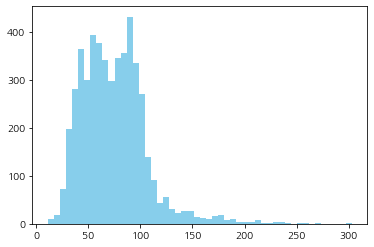

In [26]:
# 'encoded' 열의 각 리스트의 길이 계산
lengths = train_data['encoded'].apply(len)

print(f"최대 길이: {lengths.max()}")
print(f"최소 길이: {lengths.min()}")
print(f"평균 길이: {lengths.mean()}")
print(f"표준편차: {lengths.std()}")

# 길이 분포 시각화
plt.hist(lengths, bins=50, color='skyblue')
plt.show()

#### 패딩 적용

In [27]:
# 대화 최대 길이 150으로 설정
MAX_LENGTH = 150

In [28]:
X = pad_sequences(train_data['encoded'], maxlen=MAX_LENGTH, padding='post', truncating='post')

## 데이터 분할

In [29]:
y = train_data['type']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, shuffle=True, random_state=42)

print('훈련 데이터의 개수 :', len(X_train))
print('훈련 레이블의 개수 :', len(y_train))
print('검증 데이터의 개수 :', len(X_val))
print('검증 레이블의 개수 :', len(y_val))
print('테스트 데이터의 개수 :', len(X_test))
print('테스트 레이블의 개수 :', len(y_test))

훈련 데이터의 개수 : 3960
훈련 레이블의 개수 : 3960
검증 데이터의 개수 : 495
검증 레이블의 개수 : 495
테스트 데이터의 개수 : 495
테스트 레이블의 개수 : 495


In [30]:
# 테스트 데이터셋 클래스 불균형 확인
counter = Counter(y_test)
counter.most_common()

[(4, 116), (3, 115), (0, 95), (1, 89), (2, 80)]